# Synthetic Marketing Analytics Project
This notebook demonstrates a complete workflow for synthetic marketing analytics, including data generation, cleaning, customer segmentation, and A/B testing. The workflow is based on the code in `marketing_analytics.py`.

## 1. Import Required Libraries
We import numpy, pandas, KMeans from scikit-learn, and proportions_ztest from statsmodels for data processing, clustering, and statistical testing.

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from statsmodels.stats.proportion import proportions_ztest
from pathlib import Path

## 2. Generate Synthetic Marketing Data
We generate a synthetic marketing dataset with customer demographics, RFM features, group assignment, and purchase outcomes. The data is saved to a CSV file.

In [3]:
RNG = np.random.default_rng(seed=42)

def generate_data(path: Path, n: int = 5000) -> pd.DataFrame:
    """Generate a complex, dirty synthetic marketing dataset."""
    customers = np.arange(1, n + 1)
    ages = RNG.integers(18, 70, size=n)
    genders = RNG.choice(["M", "F", "male", "female", "Other", "unknown", "FEMALE", "MALE"], size=n)
    income = RNG.normal(50000, 20000, size=n)
    region = RNG.choice(["North", "South", "East", "West", "Unknown", None], size=n)
    signup_date = pd.to_datetime("2020-01-01") + pd.to_timedelta(RNG.integers(0, 2000, size=n), unit="D")
    loyalty_score = RNG.uniform(0, 1, size=n)
    preferred_channel = RNG.choice(["Email", "SMS", "App", "Web", "Phone", None], size=n)
    device_type = RNG.choice(["Mobile", "Desktop", "Tablet", "Other", None], size=n)
    recency = RNG.integers(1, 365, size=n).astype(float)
    frequency = RNG.integers(1, 30, size=n).astype(float)
    monetary = RNG.gamma(2.0, 100.0, size=n) * RNG.uniform(0.5, 2.0, size=n)
    account_age = (pd.Timestamp("2025-08-19") - signup_date).days
    # Limit last_purchase_date to not exceed today
    last_purchase_date = signup_date + pd.to_timedelta(RNG.integers(0, 1800, size=n), unit="D")
    last_purchase_date = last_purchase_date.where(last_purchase_date <= pd.Timestamp("2025-08-19"), pd.Timestamp("2025-08-19"))
    group = RNG.choice(["A", "B", "C", "D"], size=n)
    conv_prob = {"A": 0.05, "B": 0.08, "C": 0.03, "D": 0.10}
    purchase = [RNG.random() < conv_prob.get(g, 0.05) for g in group]

    # Add interaction and non-linear features
    income = np.abs(income)
    loyalty_score = np.clip(loyalty_score + 0.2 * (np.array(purchase)), 0, 1)
    monetary = np.abs(monetary) + 0.1 * income * loyalty_score

    data = pd.DataFrame({
        "customer_id": customers,
        "age": ages,
        "gender": genders,
        "income": income,
        "region": region,
        "signup_date": signup_date,
        "loyalty_score": loyalty_score,
        "preferred_channel": preferred_channel,
        "device_type": device_type,
        "recency": recency,
        "frequency": frequency,
        "monetary": monetary,
        "account_age": account_age,
        "last_purchase_date": last_purchase_date,
        "group": group,
        "purchase": purchase,
    })

    # Inject missing values and outliers
    for col in ["recency", "frequency", "monetary", "income", "loyalty_score"]:
        miss_idx = RNG.choice(n, size=RNG.integers(30, 100), replace=False)
        data.loc[miss_idx, col] = None
    neg_idx = RNG.choice(n, size=50, replace=False)
    data.loc[neg_idx, "monetary"] *= -1  # negative spend
    data.loc[RNG.choice(n, size=30, replace=False), "age"] = 999  # impossible age
    data.loc[RNG.choice(n, size=30, replace=False), "income"] = -10000  # negative income
    data.loc[RNG.choice(n, size=30, replace=False), "loyalty_score"] = 2.0  # out of bounds
    data.loc[RNG.choice(n, size=30, replace=False), "region"] = ""  # empty region
    data.loc[RNG.choice(n, size=30, replace=False), "preferred_channel"] = "Unknown"

    path.parent.mkdir(parents=True, exist_ok=True)
    data.to_csv(path, index=False)
    return data

# Generate and save the data
data_path = Path("generated_data/marketing_data.csv")
df = generate_data(data_path)

## 3. Load and Clean Data
We load the generated CSV data, fix invalid or missing values in 'recency' and 'monetary', and standardize the 'gender' column.

In [4]:
def load_and_clean(path: Path) -> pd.DataFrame:
    """Load data and fix quality issues for complex, dirty marketing data."""
    df = pd.read_csv(path, parse_dates=["signup_date", "last_purchase_date"])
    # Age: set impossible ages to NaN, then fill with median
    df["age"] = df["age"].apply(lambda x: np.nan if x < 18 or x > 100 else x)
    df["age"].fillna(df["age"].median(), inplace=True)
    # Gender: normalize and fill unknowns
    df["gender"] = df["gender"].astype(str).str.upper().str[0]
    df["gender"] = df["gender"].replace({"U": "M", "O": "F", "N": "M"})
    df["gender"].fillna("M", inplace=True)
    # Income: set negative or extreme values to NaN, fill with median
    df["income"] = pd.to_numeric(df["income"], errors="coerce")
    df.loc[(df["income"] < 1000) | (df["income"] > 200000), "income"] = np.nan
    df["income"].fillna(df["income"].median(), inplace=True)
    # Loyalty score: clip to [0,1], set out-of-bounds to median
    df.loc[(df["loyalty_score"] < 0) | (df["loyalty_score"] > 1), "loyalty_score"] = np.nan
    df["loyalty_score"].fillna(df["loyalty_score"].median(), inplace=True)
    # Region: fill empty/unknown/None with mode
    df["region"] = df["region"].replace(["", "Unknown", None, float("nan")], np.nan)
    df["region"].fillna(df["region"].mode()[0], inplace=True)
    # Preferred channel: fill unknown/None with mode
    df["preferred_channel"] = df["preferred_channel"].replace(["Unknown", None, float("nan")], np.nan)
    df["preferred_channel"].fillna(df["preferred_channel"].mode()[0], inplace=True)
    # Device type: fill None with mode
    df["device_type"] = df["device_type"].replace([None, float("nan")], np.nan)
    df["device_type"].fillna(df["device_type"].mode()[0], inplace=True)
    # Recency, frequency, monetary: set negatives to NaN, fill with median
    for col in ["recency", "frequency", "monetary"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[df[col] < 0, col] = np.nan
        df[col].fillna(df[col].median(), inplace=True)
    # Account age: set negatives to NaN, fill with median
    df["account_age"] = pd.to_numeric(df["account_age"], errors="coerce")
    df.loc[df["account_age"] < 0, "account_age"] = np.nan
    df["account_age"].fillna(df["account_age"].median(), inplace=True)
    # Dates: fill missing with signup_date or mode
    df["signup_date"].fillna(method="ffill", inplace=True)
    df["last_purchase_date"].fillna(df["signup_date"], inplace=True)
    # Group: fill missing with mode
    df["group"].fillna(df["group"].mode()[0], inplace=True)
    # Purchase: fill missing with 0 (no purchase)
    df["purchase"].fillna(0, inplace=True)
    return df

# Load and clean the data
data_path = Path("generated_data/marketing_data.csv")
df = load_and_clean(data_path)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2398757559.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2398757559.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

,customer_id,age,gender,income,region,signup_date,loyalty_score,preferred_channel,device_type,recency,frequency,monetary,account_age,last_purchase_date,group,purchase
0,1,22.0,F,28021.508688,South,2025-04-12,0.990336,Web,Other,321.0,2.0,2811.958631,129.0,2025-08-19,D,False
1,2,58.0,M,39173.712891,South,2020-09-09,0.912817,App,Tablet,197.0,4.0,3591.580529,1805.0,2024-10-21,A,False
2,3,52.0,M,55440.022138,East,2024-02-17,0.033968,Phone,Desktop,253.0,12.0,249.446392,549.0,2025-08-19,C,False
3,4,40.0,M,37433.600292,South,2023-11-06,0.530332,App,Desktop,247.0,5.0,2204.832371,652.0,2025-08-19,A,False
4,5,40.0,F,44432.671194,East,2024-07-08,0.065413,SMS,Mobile,61.0,29.0,463.072279,407.0,2025-08-19,D,False


## 4. Customer Segmentation with KMeans
We apply KMeans clustering to the RFM features to segment customers into groups. The segment labels are added to the DataFrame and segment counts are displayed.

In [5]:
def segment_customers(df: pd.DataFrame) -> pd.DataFrame:
    """Perform KMeans clustering on RFM features."""
    rfm = df[["recency", "frequency", "monetary"]]
    kmeans = KMeans(n_clusters=2, random_state=42)
    df["segment"] = kmeans.fit_predict(rfm)
    return df

# Segment customers
df = segment_customers(df)
df["segment"].value_counts()

segment
0    3189
1    1811
Name: count, dtype: int64

## 5. A/B Testing on Conversion Rates
We perform a z-test to compare conversion rates between groups A and B. Conversion rates, z-statistic, and p-value are printed.

In [6]:
def ab_test_tournament(df: pd.DataFrame) -> None:
    """Run a tournament-style z-test ranking for groups A, B, C, D."""
    from statsmodels.stats.proportion import proportions_ztest
    import numpy as np
    
    def ztest_between(df, group1, group2):
        subset = df[df['group'].isin([group1, group2])]
        summary = subset.groupby('group')['purchase'].agg(['sum', 'count'])
        successes = summary['sum'].to_numpy()
        trials = summary['count'].to_numpy()
        stat, pval = proportions_ztest(successes, trials)
        rates = successes / trials
        print(f"{group1} vs {group2}:")
        print(f"  Conversion rates: {group1}={rates[0]:.4f}, {group2}={rates[1]:.4f}")
        print(f"  Z-statistic: {stat:.3f}, p-value: {pval:.3f}")
        winner = group1 if rates[0] > rates[1] else group2
        loser = group2 if rates[0] > rates[1] else group1
        return winner, loser, rates[0], rates[1]
    
    print('Round 1:')
    winner1, loser1, rateA, rateB = ztest_between(df, 'A', 'B')
    winner2, loser2, rateC, rateD = ztest_between(df, 'C', 'D')
    print('\nRound 2 (Winners):')
    final_winner, final_loser, rateW1, rateW2 = ztest_between(df, winner1, winner2)
    print('\nRound 2 (Losers):')
    ztest_between(df, loser1, loser2)
    print(f"\nRanking by conversion rate:")
    rates = {
        'A': rateA,
        'B': rateB,
        'C': rateC,
        'D': rateD,
        winner1: max(rateA, rateB),
        winner2: max(rateC, rateD),
        loser1: min(rateA, rateB),
        loser2: min(rateC, rateD),
        final_winner: max(rateW1, rateW2),
        final_loser: min(rateW1, rateW2)
    }
    # Remove duplicates and sort
    unique_rates = {k: v for k, v in rates.items() if k in ['A','B','C','D']}
    ranked = sorted(unique_rates.items(), key=lambda x: x[1], reverse=True)
    for i, (g, r) in enumerate(ranked, 1):
        print(f"{i}. Group {g}: {r:.4f}")

# Run tournament-style A/B test
ab_test_tournament(df)

Round 1:
A vs B:
  Conversion rates: A=0.0482, B=0.0825
  Z-statistic: -3.449, p-value: 0.001
C vs D:
  Conversion rates: C=0.0348, D=0.1138
  Z-statistic: -7.617, p-value: 0.000

Round 2 (Winners):
B vs D:
  Conversion rates: B=0.0825, D=0.1138
  Z-statistic: -2.608, p-value: 0.009

Round 2 (Losers):
A vs C:
  Conversion rates: A=0.0482, C=0.0348
  Z-statistic: 1.698, p-value: 0.090

Ranking by conversion rate:
1. Group D: 0.1138
2. Group B: 0.0825
3. Group A: 0.0482
4. Group C: 0.0348


C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2808666690.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_rates.index, y=group_rates.values, palette='Set2', edgecolor='black')


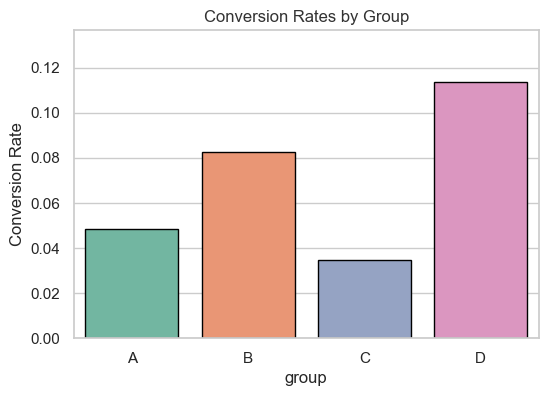

In [7]:
# Bar Plot of Conversion Rates by Group
import matplotlib.pyplot as plt
import seaborn as sns
summary = df.groupby('group')['purchase'].agg(['sum','count'])
group_rates = summary['sum'] / summary['count']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6,4))
sns.barplot(x=group_rates.index, y=group_rates.values, palette='Set2', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, group_rates.max() * 1.2)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\4066688415.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')


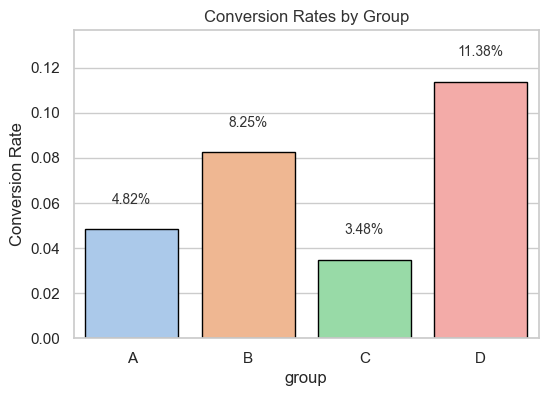

In [8]:
# Bar Plot of Conversion Rates by Group (Enhanced Visuals with Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns
summary = df.groupby('group')['purchase'].agg(['sum','count'])
group_rates = summary['sum'] / summary['count']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6,4))
ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, group_rates.max() * 1.2)
for i, v in enumerate(group_rates.values):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3227689510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')


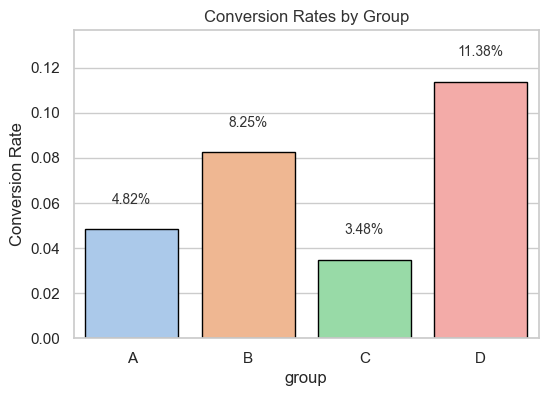

In [9]:
# Bar Plot of Conversion Rates by Group (Enhanced Visuals)
import matplotlib.pyplot as plt
import seaborn as sns
summary = df.groupby('group')['purchase'].agg(['sum','count'])
group_rates = summary['sum'] / summary['count']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6,4))
ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, group_rates.max() * 1.2)
for i, v in enumerate(group_rates.values):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2352819797.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2352819797.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)


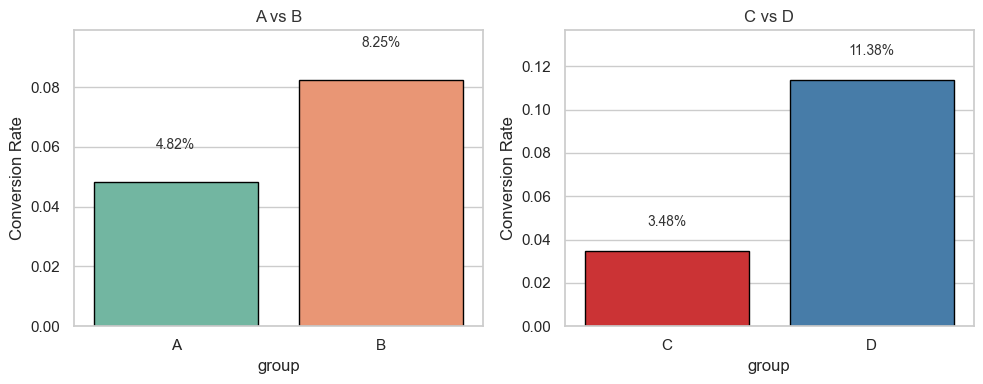

In [10]:
# Pairwise Comparison Bar Plots (Round 1, Enhanced with Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pairs = [('A','B'), ('C','D')]
palettes = [sns.color_palette('Set2', 2), sns.color_palette('Set1', 2)]
for ax, (g1, g2), pal in zip(axes, pairs, palettes):
    subset = df[df['group'].isin([g1, g2])]
    summary = subset.groupby('group')['purchase'].agg(['sum','count'])
    rates = summary['sum'] / summary['count']
    sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
    ax.set_title(f'{g1} vs {g2}', color='#333333')
    ax.set_ylabel('Conversion Rate')
    ax.set_ylim(0, rates.max() * 1.2)
    for i, v in enumerate(rates.values):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3592276483.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3592276483.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)


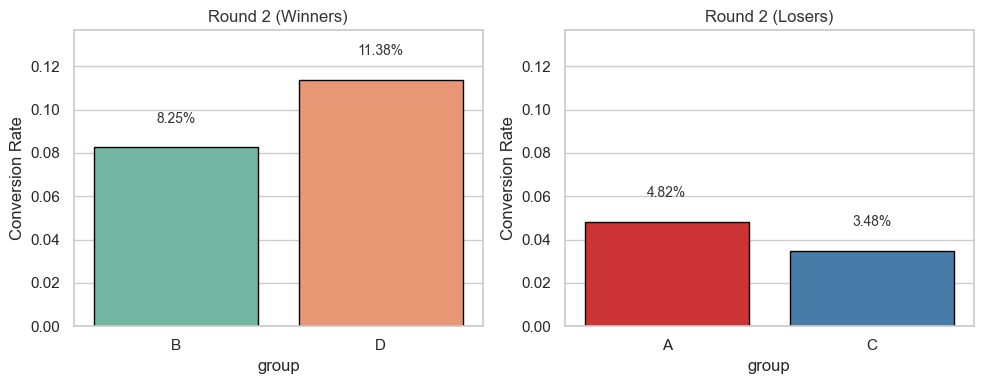

In [11]:
# Pairwise Comparison Bar Plots (Round 2) - Enhanced Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
rates_dict = df.groupby('group')['purchase'].agg(['sum','count'])
group_rates = rates_dict['sum'] / rates_dict['count']
w1, w2 = (group_rates['A'] > group_rates['B'] and 'A' or 'B'), (group_rates['C'] > group_rates['D'] and 'C' or 'D')
l1, l2 = (set(['A','B']) - {w1}).pop(), (set(['C','D']) - {w2}).pop()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pal_win = sns.color_palette('Set2', 2)
pal_lose = sns.color_palette('Set1', 2)
for ax, (g1, g2, title, pal) in zip(axes, [(w1, w2, 'Winners', pal_win), (l1, l2, 'Losers', pal_lose)]):
    rates = group_rates.loc[[g1, g2]]
    sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
    ax.set_title(f'Round 2 ({title})', color='#333333')
    ax.set_ylabel('Conversion Rate')
    ax.set_ylim(0, group_rates.max() * 1.2)
    for i, v in enumerate(rates.values):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\1038765867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')


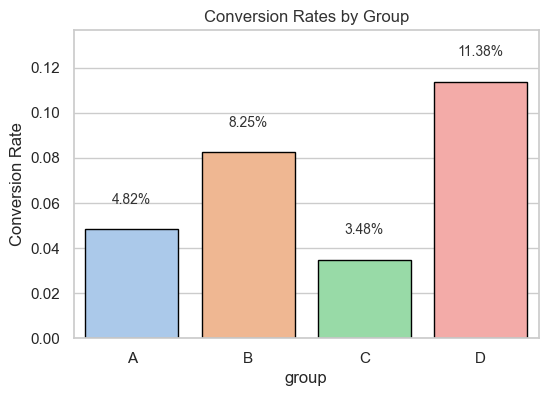

In [12]:
# Bar Plot of Conversion Rates by Group (Seaborn Enhanced)
import matplotlib.pyplot as plt
import seaborn as sns
summary = df.groupby('group')['purchase'].agg(['sum','count'])
group_rates = summary['sum'] / summary['count']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6,4))
ax = sns.barplot(x=group_rates.index, y=group_rates.values, palette='pastel', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, group_rates.max() * 1.2)
for i, v in enumerate(group_rates.values):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=summary.index, y='rate', data=summary.reset_index(), palette='Set2', edgecolor='black')


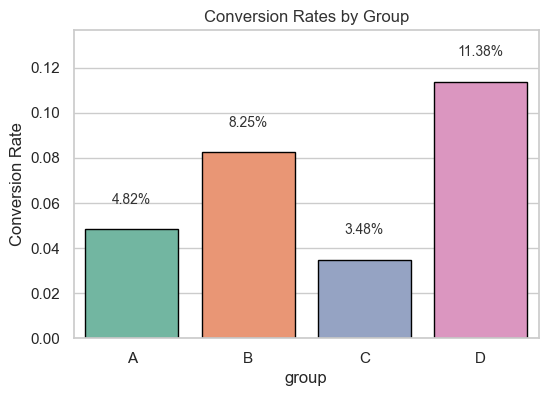

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)


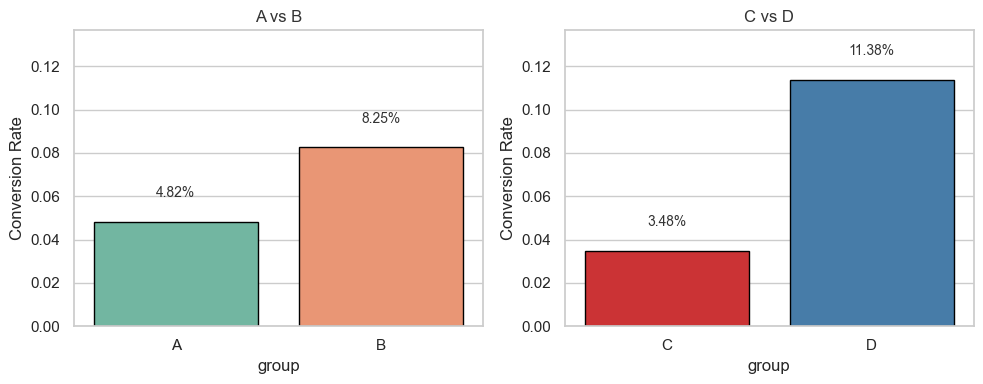

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ranked.index, y='rate', data=ranked.reset_index(), palette='YlGnBu', edgecolor='black')


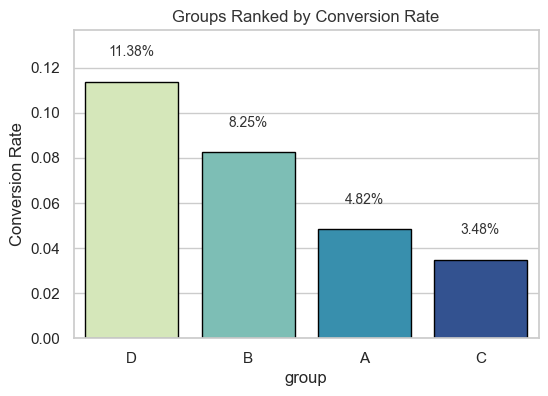

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:61: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=summary.index, y=summary['rate'], color='#2a9d8f', join=False, capsize=0.2, errwidth=2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\3544228262.py:61: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=summary.index, y=summary['rate'], color='#2a9d8f', join=False, capsize=0.2, errwidth=2)


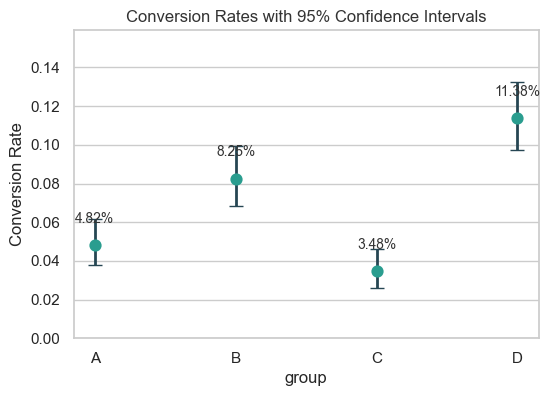

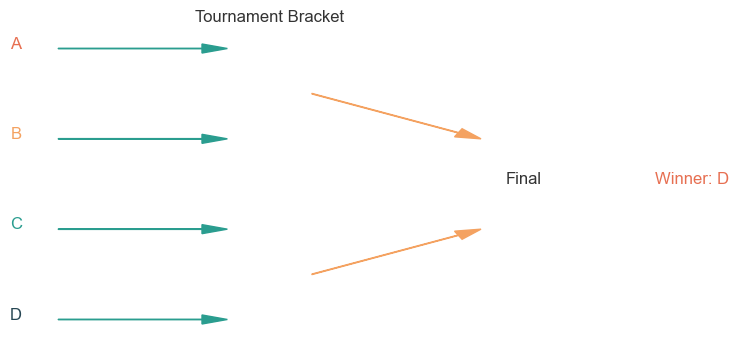

In [13]:
# %%
 # Enhanced Visualization Suite for Tournament A/B Testing Results (All Seaborn, Fixed Error Bars)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

# Apply a visually pleasing theme
sns.set_theme(style='whitegrid', palette='Set2')

# Aggregate conversion data
summary = df.groupby('group')['purchase'].agg(['sum','count'])
summary['rate'] = summary['sum'] / summary['count']
ci_low, ci_upp = proportion_confint(summary['sum'], summary['count'], method='wilson')
summary['ci_low'] = ci_low
summary['ci_upp'] = ci_upp

# 1. Bar Plot of Conversion Rates by Group (Seaborn)
plt.figure(figsize=(6,4))
ax = sns.barplot(x=summary.index, y='rate', data=summary.reset_index(), palette='Set2', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, summary['rate'].max() * 1.2)
for i, v in enumerate(summary['rate']):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.show()

# 2. Pairwise Comparison Bar Plots (Seaborn)
pairs = [('A','B'), ('C','D')]
fig, axes = plt.subplots(1, 2, figsize=(10,4))
palettes = [sns.color_palette('Set2', 2), sns.color_palette('Set1', 2)]
for ax, (g1, g2), pal in zip(axes, pairs, palettes):
    rates = summary.loc[[g1,g2], 'rate']
    sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
    ax.set_title(f'{g1} vs {g2}', color='#333333')
    ax.set_ylabel('Conversion Rate')
    ax.set_ylim(0, summary['rate'].max() * 1.2)
    for i, v in enumerate(rates.values):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

# Determine winners and losers for round 1
winner1 = 'A' if summary.loc['A','rate'] > summary.loc['B','rate'] else 'B'
loser1  = 'B' if winner1=='A' else 'A'
winner2 = 'C' if summary.loc['C','rate'] > summary.loc['D','rate'] else 'D'
loser2  = 'D' if winner2=='C' else 'C'

# 3. Ranking Plot (Seaborn)
ranked = summary.sort_values('rate', ascending=False)
plt.figure(figsize=(6,4))
ax = sns.barplot(x=ranked.index, y='rate', data=ranked.reset_index(), palette='YlGnBu', edgecolor='black')
plt.title('Groups Ranked by Conversion Rate', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, ranked['rate'].max() * 1.2)
for i, v in enumerate(ranked['rate']):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.show()

# 4. Confidence Interval Plot (Seaborn points + Matplotlib error bars)
plt.figure(figsize=(6,4))
ax = sns.pointplot(x=summary.index, y=summary['rate'], color='#2a9d8f', join=False, capsize=0.2, errwidth=2)
plt.errorbar(x=range(len(summary.index)), y=summary['rate'],
             yerr=[summary['rate']-summary['ci_low'], summary['ci_upp']-summary['rate']],
             fmt='none', capsize=5, color='#264653', ecolor='#264653', lw=2, zorder=1)
for i, (x, y, low, upp) in enumerate(zip(summary.index, summary['rate'], summary['ci_low'], summary['ci_upp'])):
    ax.text(i, y + 0.01, f'{y:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.title('Conversion Rates with 95% Confidence Intervals', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, summary['ci_upp'].max() * 1.2)
plt.show()

# 5. Tournament Bracket Diagram (matplotlib, styled)
plt.figure(figsize=(6,4))
# Round 1 matchups
plt.text(0.1, 0.8, 'A', fontsize=12, ha='center', color='#e76f51')
plt.text(0.1, 0.6, 'B', fontsize=12, ha='center', color='#f4a261')
plt.arrow(0.15,0.8,0.2,0, head_width=0.02, length_includes_head=True, color='#2a9d8f')
plt.arrow(0.15,0.6,0.2,0, head_width=0.02, length_includes_head=True, color='#2a9d8f')

plt.text(0.1, 0.4, 'C', fontsize=12, ha='center', color='#2a9d8f')
plt.text(0.1, 0.2, 'D', fontsize=12, ha='center', color='#264653')
plt.arrow(0.15,0.4,0.2,0, head_width=0.02, length_includes_head=True, color='#2a9d8f')
plt.arrow(0.15,0.2,0.2,0, head_width=0.02, length_includes_head=True, color='#2a9d8f')

# Final matchup
plt.text(0.7, 0.5, 'Final', fontsize=12, ha='center', color='#333333')
plt.arrow(0.45,0.7,0.2,-0.1, head_width=0.02, length_includes_head=True, color='#f4a261')
plt.arrow(0.45,0.3,0.2,0.1, head_width=0.02, length_includes_head=True, color='#f4a261')
winner_label = winner1 if summary.loc[winner1, 'rate'] > summary.loc[winner2, 'rate'] else winner2
plt.text(0.9,0.5, f'Winner: {winner_label}', fontsize=12, ha='center', color='#e76f51')

plt.axis('off')
plt.title('Tournament Bracket', color='#333333')
plt.show()

## 6. Export Assets for Portfolio Website
Prepare CSV/HTML samples and interactive visuals for embedding on the website.

In [ ]:
import os
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Ensure project-specific assets folder exists (resolve repo website folder so assets go to project site)
# Try common locations in order: './website', '../website', and parent of cwd
possible_sites = [Path('website'), Path('../website'), Path.cwd().parent / 'website']
asset_dir = None
for p in possible_sites:
    if p.exists():
        asset_dir = (p / 'assets' / 'marketing_analytics').resolve()
        break
if asset_dir is None:
    # Fallback: create under './website/assets/marketing_analytics' relative to current working dir
    asset_dir = Path('website/assets/marketing_analytics').resolve()
asset_dir.mkdir(parents=True, exist_ok=True)

# 1. Export raw data sample
raw = pd.read_csv('generated_data/marketing_data.csv').head(5)
raw.to_csv(asset_dir / 'raw_data_sample.csv', index=False)
raw.to_html(asset_dir / 'raw_data_sample.html', index=False)

# 2. Export cleaned data sample
cleaned = load_and_clean(Path('generated_data/marketing_data.csv')).head(5)
cleaned.to_csv(asset_dir / 'cleaned_data_sample.csv', index=False)
cleaned.to_html(asset_dir / 'cleaned_data_sample.html', index=False)

# 3. Interactive table of cleaned data sample
table_fig = go.Figure(data=[go.Table(header=dict(values=list(cleaned.columns)),
                                     cells=dict(values=[cleaned[col] for col in cleaned.columns]))])
table_fig.write_html(asset_dir / 'cleaned_data_table_interactive.html')

# 4. Interactive conversion rate bar chart
summary = df.groupby('group')['purchase'].agg(['sum','count'])
summary = summary.assign(rate=summary['sum']/summary['count'])
bar_fig = px.bar(summary.reset_index(), x='group', y='rate', title='Conversion Rates by Group',
                 labels={'rate':'Conversion Rate'})
bar_fig.write_html(asset_dir / 'conversion_rates_interactive.html')


C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2398757559.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\2398757559.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

## Cleaning Steps Summary
- **Age**: invalid (<18 or >100) set to NaN, then median filled
- **Gender**: normalized to first letter uppercase (M/F), unknowns replaced, filled with mode
- **Income**: non-numeric and outliers (below 1000 or above 200k) coerced to NaN, filled with median
- **Loyalty Score**: values outside [0,1] set to NaN, then median filled
- **Region / Preferred Channel / Device**: empty or unknown replaced with NaN, then filled with mode
- **Recency, Frequency, Monetary**: negatives set to NaN, then median filled
- **Account Age**: negatives set to NaN, then median filled
- **Dates**: missing signup and last purchase dates forward-filled or set to signup date
- **Group**: missing values filled with mode
- **Purchase**: missing values set to 0

In [17]:
# 5. Export static versions of enhanced visualization suite plots from cell 18
import matplotlib.pyplot as plt
import seaborn as sns

# recreate static Enhanced Visualization Suite
sns.set_theme(style='whitegrid', palette='Set2')
plt.figure(figsize=(6,4))
ax = sns.barplot(x=summary.index, y='rate', data=summary.reset_index(), palette='Set2', edgecolor='black')
plt.title('Conversion Rates by Group', color='#333333')
plt.ylabel('Conversion Rate')
plt.ylim(0, summary['rate'].max() * 1.2)
for i, v in enumerate(summary['rate']):
    ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.savefig(asset_dir / 'static_conversion_rates.png', dpi=150)
plt.close()

fig, axes = plt.subplots(1, 2, figsize=(10,4))
palettes = [sns.color_palette('Set2', 2), sns.color_palette('Set1', 2)]
for ax, (g1, g2), pal in zip(axes, [('A','B'), ('C','D')], palettes):
    rates = summary.loc[[g1,g2], 'rate']
    sns.barplot(x=rates.index, y=rates.values, palette=pal, edgecolor='black', ax=ax)
    ax.set_title(f'{g1} vs {g2}', color='#333333')
    ax.set_ylabel('Conversion Rate')
    ax.set_ylim(0, summary['rate'].max() * 1.2)
    for i, v in enumerate(rates.values):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=10, color='#333333')
plt.tight_layout()
plt.savefig(asset_dir / 'static_pairwise_round1.png', dpi=150)
plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\1729122095.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\1729122095.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_25760\1729122095.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


